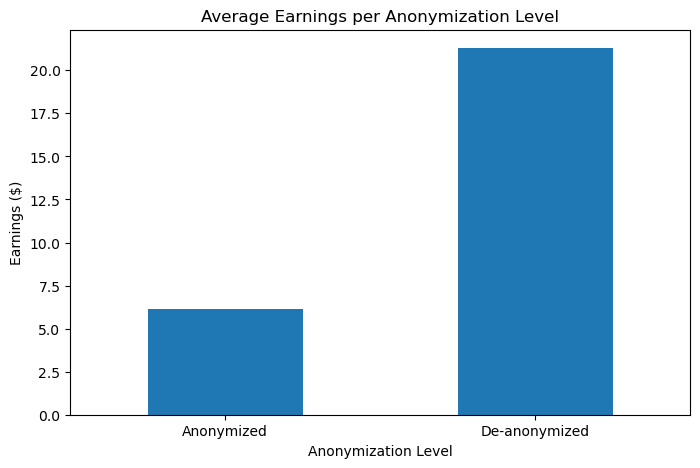

In [3]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Define User Class with Privacy Sensitivity (v)
class User:
    def __init__(self, user_id, statements, privacy_sensitivity):
        """
        statements: List of preference statements, where each statement is a dictionary
        Example:
        [
            {"A": "De-anonymized", "P": "Advertisers", "R": ["Targeted Ads", "Email Marketing"]},
            {"A": "Anonymized", "P": "Retailers", "R": ["Market Research"]}
        ]
        privacy_sensitivity: Dict mapping (P, R, A) tuples to a sensitivity value (0-1), where 1 means highly private.
        """
        self.user_id = user_id
        self.statements = statements  # List of user data-sharing statements
        self.privacy_sensitivity = privacy_sensitivity  # Dict mapping (P, R, A) to privacy sensitivity
        self.earnings = 0

    def get_relevant_statements(self, platform_type):
        """Returns all statements that match a given platform type."""
        return [s for s in self.statements if s["P"] == platform_type]

    def get_privacy_sensitivity(self, platform, purpose, anonymization):
        """Returns privacy sensitivity for a specific (P, R, A) tuple."""
        return self.privacy_sensitivity.get((platform, purpose, anonymization), 0.5)  # Default sensitivity is 0.5


# Define Platform Class with Purpose-Based Profitability Factors (δR)
class Platform:
    def __init__(self, platform_type, budget, value_per_purpose, profitability_factors):
        """
        platform_type: "Advertisers" or "Retailers"
        budget: Total budget for data purchases
        value_per_purpose: Dict {Purpose: Base Value}
        profitability_factors: Dict {Purpose: Profitability Factor δR}
        Example:
        {"Targeted Ads": 50, "Email Marketing": 30}, {"Targeted Ads": 1.2, "Email Marketing": 1.0}
        """
        self.platform_type = platform_type
        self.budget = budget
        self.value_per_purpose = value_per_purpose
        self.profitability_factors = profitability_factors

    def bid_for_data(self, purpose, anonymization, user_privacy_sensitivity):
        """Determines bid amount based on anonymization, purpose profitability, and user privacy sensitivity."""
        if purpose not in self.value_per_purpose:
            return 0  # Platform doesn’t need this data
        
        base_value = self.value_per_purpose[purpose]
        profitability_factor = self.profitability_factors.get(purpose, 1.0)

        # Adjust pricing based on anonymization and privacy sensitivity
        price = base_value * profitability_factor * (1 - user_privacy_sensitivity)
        price = price if anonymization == "De-anonymized" else price * 0.5  # Anonymized data worth less

        return min(price, self.budget)  # Platform won't exceed budget


# Define Broker (Papaya) Class with Data Union Effect
class Broker:
    def __init__(self, commission_rate=0.1):
        self.commission_rate = commission_rate  # Papaya takes a small cut
        self.union_factor = {}  # Tracks how many users opt into the same (P, R, A)

    def process_transactions(self, users, platforms):
        total_transactions = 0
        earnings_data = []

        # Reset union tracking per round
        self.union_factor.clear()

        # First pass: Count (P, R, A) participation for union effect
        for user in users:
            for statement in user.statements:
                key = (statement["P"], tuple(statement["R"]), statement["A"])
                self.union_factor[key] = self.union_factor.get(key, 0) + 1

        # Second pass: Execute transactions with union impact
        for user in users:
            for platform in platforms:
                user_statements = user.get_relevant_statements(platform.platform_type)
                for statement in user_statements:
                    for purpose in statement["R"]:
                        privacy_sensitivity = user.get_privacy_sensitivity(platform.platform_type, purpose, statement["A"])
                        price = platform.bid_for_data(purpose, statement["A"], privacy_sensitivity)
                        
                        if price > 0:
                            # Apply Data Union effect: Higher participation boosts payments
                            union_multiplier = 1 + (self.union_factor[(platform.platform_type, tuple(statement["R"]), statement["A"])] * 0.05)
                            price *= union_multiplier

                            payout = price * (1 - self.commission_rate)
                            user.earnings += payout  # Pay user
                            platform.budget -= price
                            total_transactions += 1

                            # Collect transaction data for analysis
                            earnings_data.append({
                                "User_ID": user.user_id,
                                "Platform": platform.platform_type,
                                "Purpose": purpose,
                                "Anonymization": statement["A"],
                                "Privacy Sensitivity": privacy_sensitivity,
                                "Union Effect": union_multiplier,
                                "Earnings": payout
                            })

        return total_transactions, earnings_data


# Initialize platforms with purpose-based profitability factors
platforms = [
    Platform("Advertisers", budget=5000, value_per_purpose={"Targeted Ads": 50, "Email Marketing": 30},
             profitability_factors={"Targeted Ads": 1.2, "Email Marketing": 1.0}),
    Platform("Retailers", budget=4000, value_per_purpose={"Market Research": 40, "Product Recommendation": 25},
             profitability_factors={"Market Research": 1.1, "Product Recommendation": 0.9}),
]

# Define users with structured (P, R, A) preferences and privacy sensitivity
users = [
    User(1, [
        {"A": "De-anonymized", "P": "Advertisers", "R": ["Targeted Ads", "Email Marketing"]},
        {"A": "Anonymized", "P": "Retailers", "R": ["Market Research"]}
    ], {("Advertisers", "Targeted Ads", "De-anonymized"): 0.3, ("Retailers", "Market Research", "Anonymized"): 0.8}),

    User(2, [
        {"A": "Anonymized", "P": "Advertisers", "R": ["Email Marketing"]},
        {"A": "De-anonymized", "P": "Retailers", "R": ["Product Recommendation"]}
    ], {("Advertisers", "Email Marketing", "Anonymized"): 0.6, ("Retailers", "Product Recommendation", "De-anonymized"): 0.2}),

    User(3, [
        {"A": "Anonymized", "P": "Advertisers", "R": ["Targeted Ads"]},
        {"A": "De-anonymized", "P": "Retailers", "R": ["Market Research", "Product Recommendation"]}
    ], {("Advertisers", "Targeted Ads", "Anonymized"): 0.7, ("Retailers", "Market Research", "De-anonymized"): 0.4}),
]

# Initialize the broker
broker = Broker(commission_rate=0.1)

# Run the simulation for multiple rounds and collect data
NUM_ROUNDS = 20
all_earnings_data = []

for round in range(NUM_ROUNDS):
    transactions, earnings_data = broker.process_transactions(users, platforms)
    all_earnings_data.extend(earnings_data)

# Convert results to a DataFrame
df = pd.DataFrame(all_earnings_data)

# Aggregate results for analysis
earnings_by_anonymization = df.groupby("Anonymization")["Earnings"].mean()
earnings_by_purpose = df.groupby("Purpose")["Earnings"].mean()
platform_spending = df.groupby("Platform")["Earnings"].sum()

# Plot results
plt.figure(figsize=(8, 5))
earnings_by_anonymization.plot(kind="bar")
plt.title("Average Earnings per Anonymization Level")
plt.ylabel("Earnings ($)")
plt.xlabel("Anonymization Level")
plt.xticks(rotation=0)
plt.show()


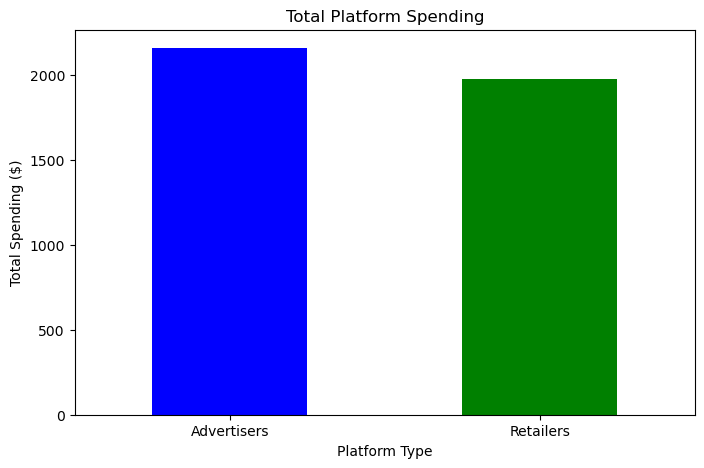

In [13]:
# Plot platform spending distribution
plt.figure(figsize=(8, 5))
platform_spending.plot(kind="bar", color=["blue", "green"])
plt.title("Total Platform Spending")
plt.ylabel("Total Spending ($)")
plt.xlabel("Platform Type")
plt.xticks(rotation=0)
plt.show()

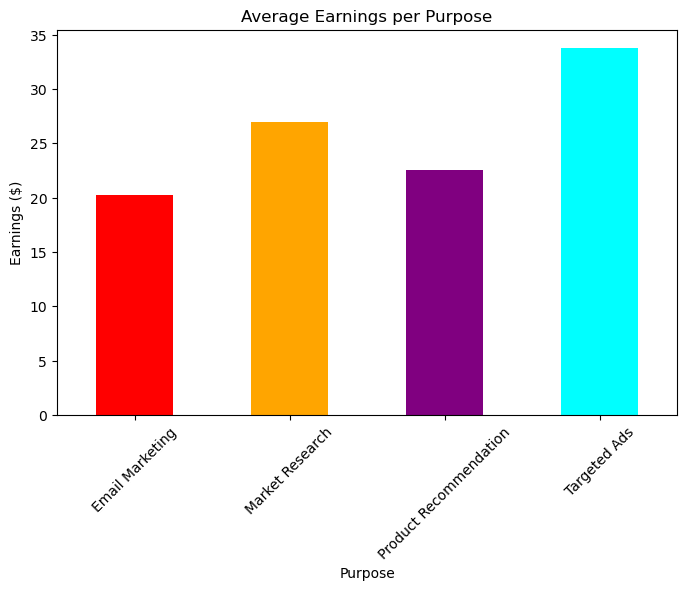

In [14]:
# Plot earnings distribution across purposes
plt.figure(figsize=(8, 5))
earnings_by_purpose.plot(kind="bar", color=["red", "orange", "purple", "cyan"])
plt.title("Average Earnings per Purpose")
plt.ylabel("Earnings ($)")
plt.xlabel("Purpose")
plt.xticks(rotation=45)
plt.show()

In [15]:
df

,User_ID,Platform,Purpose,Anonymization,Earnings
0,1,Advertisers,Targeted Ads,De-anonymized,45.0
1,1,Advertisers,Email Marketing,De-anonymized,27.0
2,1,Retailers,Market Research,Anonymized,18.0
3,2,Advertisers,Email Marketing,Anonymized,13.5
4,2,Retailers,Product Recommendation,De-anonymized,22.5
...,...,...,...,...,...
155,2,Advertisers,Email Marketing,Anonymized,13.5
156,2,Retailers,Product Recommendation,De-anonymized,22.5
157,3,Advertisers,Targeted Ads,Anonymized,22.5
158,3,Retailers,Market Research,De-anonymized,36.0
